# X-ray Speckle Visibility Spectroscopy

The analysis module "skxray/core/xsvs"
https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/xsvs.py


In [1]:
import skxray.core.xsvs as xsvs
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

import xray_vision.mpl_plotting as mpl_plot
import xray_vision.mpl_plotting.speckle as speckle_plot

import numpy as np
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

# Easily switch between interactive and static matplotlib plots

In [2]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

# This data provided by Dr. Andrei Fluerasu
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu , "Photon statistics and speckle visibility spectroscopy with partially coherent x-rays" J. Synchrotron Rad., vol 21, p 1288-1295, 2014.


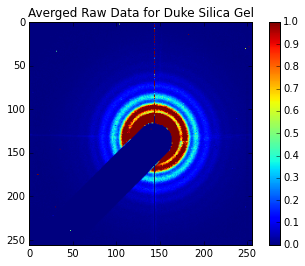

In [3]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/Duke_data/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)

avg_raw = np.average(duke_data, axis=0)

plt.figure()
plt.imshow(avg_raw, vmin=0, vmax=1e0)
plt.title("Averged Raw Data for Duke Silica Gel")
plt.colorbar()
plt.show()

# Masking
different masks can be multiplied or added to create a combined mask

## Masks can be created using xray_vision/mask/manual_mask   module
https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

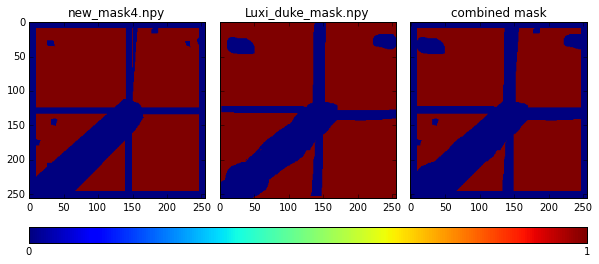

In [4]:
mask4 = np.load(data_dir+"new_mask4.npy")
mask = np.load(data_dir+"Luxi_duke_mask.npy")

# mask can be multiplied or added in the follwoing way
N_mask = (~mask * ~mask4)
#or N_mask = ~(mask + mask4)

fig = plt.figure(figsize=(10, 4))

grid = ImageGrid(fig, '111', nrows_ncols=(1, 3), share_all=True, 
                 axes_pad=0.2, label_mode="L", cbar_location="bottom", 
                 cbar_mode="single", cbar_size='3%')
# plot the images
im1 = grid[0].imshow(~mask)
im2 = grid[1].imshow(~mask4)
im3 = grid[2].imshow(N_mask)

# instantiate the colorbar
grid.cbar_axes[0].colorbar(im3, ticks=MaxNLocator(integer=True))

# set the titles of the axes
grid[0].set_title('new_mask4.npy')
grid[1].set_title('Luxi_duke_mask.npy')
grid[2].set_title('combined mask')

if 'inline' in backend:
    plt.show()

# Compared the raw averge and masked averge  for Duke silica data

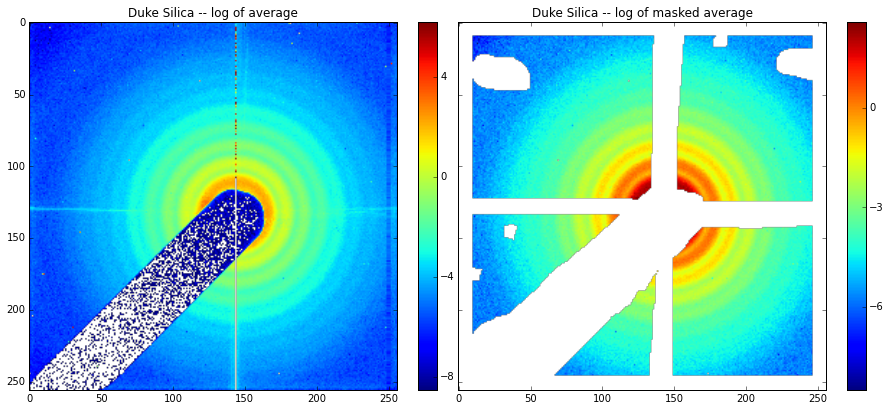

In [5]:
avg_masked = avg_raw*N_mask

fig = plt.figure(figsize=(15, 7))
grid = ImageGrid(fig, (1,1,1), nrows_ncols=(1, 2), share_all=True, 
                 cbar_mode='each', axes_pad=.3)
cmap = 'jet'
im1 = grid[0].imshow(np.log(avg_raw), cmap=cmap)
im2 = grid[1].imshow(np.log(avg_masked), cmap=cmap)

grid[0].set_title("Duke Silica -- log of average")
grid[1].set_title("Duke Silica -- log of masked average")

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
# the following code is needed to make it easy to switch 
# between '%matplotlib inline' and '%matplotlib notebook'
if 'inline' in backend:
    plt.show()

# Get the circular average(radial integration) of the masked average data
##used the roi.circular_average

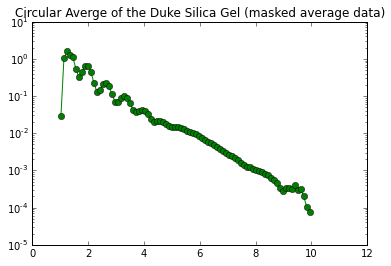

In [6]:
est_center = (133, 143)  # center of the speckle pattern 
dpix =0.055

bin_centers, ring_averages= roi.circular_average(avg_raw*N_mask, est_center, threshold=0, nx=100,
                                         pixel_size=(dpix, dpix))
line_color="green"
line_style='o'
plt.figure()
plt.semilogy(bin_centers, ring_averages, c=line_color, marker=line_style )
plt.title("Circular Averge of the Duke Silica Gel (masked average data)")
plt.show()

# Use the skxray.core.roi module to create Ring ROIs(ROI Mask)

In [7]:
inner_radius = 26
width = 1
spacing = 0
num_rings = 4

#  create edges of the rings using roi.ring_edges
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.],
       [ 29.,  30.]])

## create a labeled array using roi.rings

In [8]:
rings = roi.rings(edges, est_center, avg_raw.shape)

rings_mask = rings*N_mask


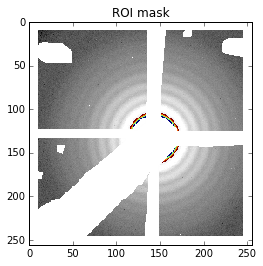

In [9]:
def test_demo(ax, label_array, img_dim, image):
    """
    This will plot the reqiured roi's on the image
    """
    vmin, vmax = np.percentile(image, [100, 100])
    im = ax.imshow(image, cmap='gist_gray', interpolation='none', norm=LogNorm(), vmax=1e0)
    im = ax.imshow(label_array, interpolation='none', norm=LogNorm())
    
fig, ax = plt.subplots()
plt.title("ROI mask")
test_demo(ax, rings_mask, avg_masked.shape, avg_masked)
plt.show()

# Convert the ring edges to q (reciprocal values)¶

In [10]:
dpix = 0.055
lambda_ = 1.5498  # wavelength
Ldet = 2200.   #   # distance to sample

two_theta = core.radius_to_twotheta(Ldet, edges*dpix)
q_val = core.twotheta_to_q(two_theta, lambda_)
q_val

array([[ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929],
       [ 0.00293929,  0.00304064]])

## center of the rings

In [11]:
q_cen = np.mean(q_val, axis=1)
q_cen

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

In [12]:
images_sets = (N_mask*duke_data,)

mean_int_sets, index_list = roi.mean_intensity_sets(images_sets, rings_mask)
combine_intensity = roi.combine_mean_intensity(mean_int_sets, index_list)

In [13]:
mean_int_ring = np.mean(combine_intensity, axis=0)
mean_int_ring


array([ 3.17503051,  2.03199322,  1.22062687,  0.78536136])

#  Find the brightest pixel in any ROI in any image in the image set. 
## Using roi_max_counts function from skxray.core.roi module

In [14]:
max_cts = roi.roi_max_counts(images_sets, rings_mask)
max_cts

24

#  Everything looks good, next X-ray speckle visibilty spectroscopy
## This function will provide the probability density of detecting photons
##    for different integration time.

## Using skxray.core.xsvs module

In [15]:
spe_cts_all, std_dev = xsvs.xsvs(images_sets, rings_mask, timebin_num=2,
                             number_of_img=50, max_cts=max_cts)

In [17]:
num_times = 6
num_rois=num_rings
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

# Find the integration times using skxray.core.utils.geometric_series

In [19]:
time_steps = core.geometric_series(2, 50)
time_steps

[1, 2, 4, 8, 16, 32]

#1st q ring 0.0026859 (1/Angstroms)¶

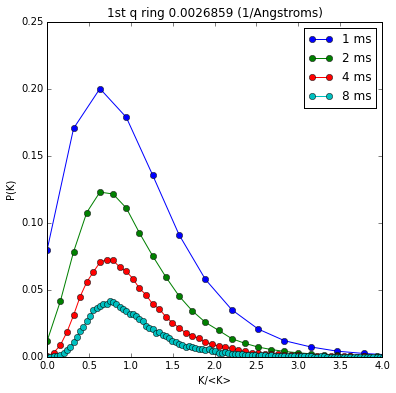

In [27]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring 0.0026859 (1/Angstroms)")
plt.show()

#2nd q ring 0.00278726 (1/Angstroms)¶

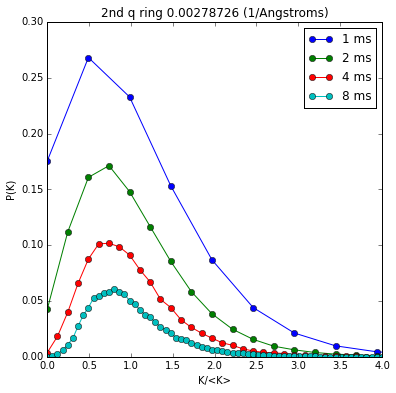

In [28]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], spe_cts_all[i, 1], '-o', label=str(time_steps[i])+" ms")
    axes.legend()
    axes.set_xlim(0, 4)
plt.title("2nd q ring 0.00278726 (1/Angstroms)")
plt.show()

# 3rd q ring 0.00288861 (1/ Angstroms)

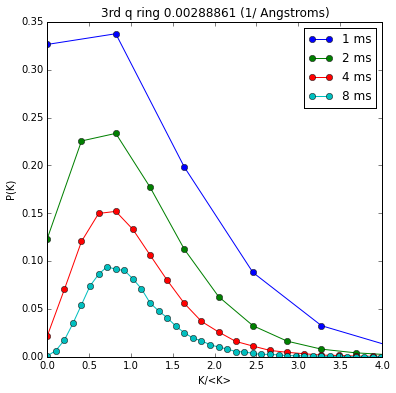

In [29]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 2][:-1], spe_cts_all[i, 2], '-o', label=str(time_steps[i])+" ms" )
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("3rd q ring 0.00288861 (1/ Angstroms)")
plt.show()

# 4th q ring 0.0298997 (1/ Angstroms)

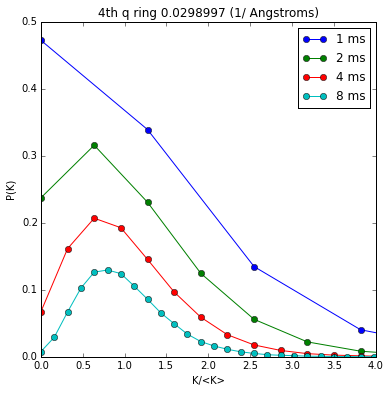

In [30]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 3][:-1], spe_cts_all[i, 3], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("4th q ring 0.0298997 (1/ Angstroms)")
plt.show()